In [1]:
from osgeo import gdal
import numpy as np
import imageio
import pandas as pd
from affine import Affine
import geopandas as gpd
from sklearn.cluster import OPTICS
from shapely.geometry import Polygon
import matplotlib.pyplot as plt

from dem_utils_examples import load_rast, th_vals, plot_rast, gdal_process, load_json

## Preparation of the rasters

Calculate the height parameters

In [3]:
#We load the cropped raster
dem_cropped_path = './notebook_outputs/rasters/dem_cropped.tif'

dem_cropped = load_rast.open_raster_array(dem_cropped_path)
imageio.imwrite('./notebook_outputs/rasters/dem_cropped_imageio.tif', dem_cropped)

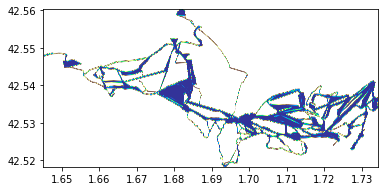

In [4]:
plot_rast.quick_show_rasterio(dem_cropped_path)

In [5]:
#Get the metadata of the raster to define conditions: 
min_val = np.min(dem_cropped)
dem_cropped_array = np.where(dem_cropped > 3.399e38, 0., dem_cropped)

print('Min_Elev: ', min_val, ' Max_Elev: ', np.max(dem_cropped_array))

Min_Elev:  1931.994  Max_Elev:  2669.111


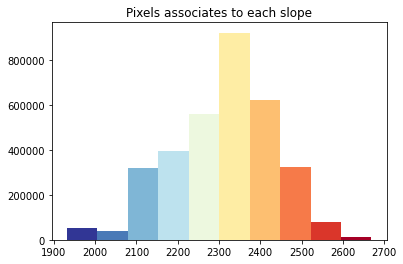

In [6]:
saet_notnan = dem_cropped_array[~np.isnan(dem_cropped_array)] #We set all the NaN values to 0 in order to correctly plot the percentatges
saet_notnan = np.nan_to_num(saet_notnan)
saet_notnan = saet_notnan[saet_notnan!=0]
#Plot Histogram: 
cm = plt.cm.get_cmap('RdYlBu_r')
n, bins, patches = plt.hist(saet_notnan, 10, color='Green')
bin_centers = 0.5 * (bins[:-1] + bins[1:])

col = bin_centers - min(bin_centers)
col /= max(col)

for c, p in zip(col, patches):
    plt.setp(p, 'facecolor', cm(c))
plt.title('Pixels associates to each slope')
#plt.savefig('./outputs/images/altitude_hist.png')
plt.show()

Calculate the hillshade profile of the image: 

In [9]:
hillshade_path = './notebook_outputs/rasters/dem_hillshade.tif'
trails_hillshade = gdal_process.calculate_hillshade_dem(dem_cropped_path, hillshade_path)

In [12]:
load_rast.write_raster_array(trails_hillshade, dem_cropped_path, hillshade_path) 

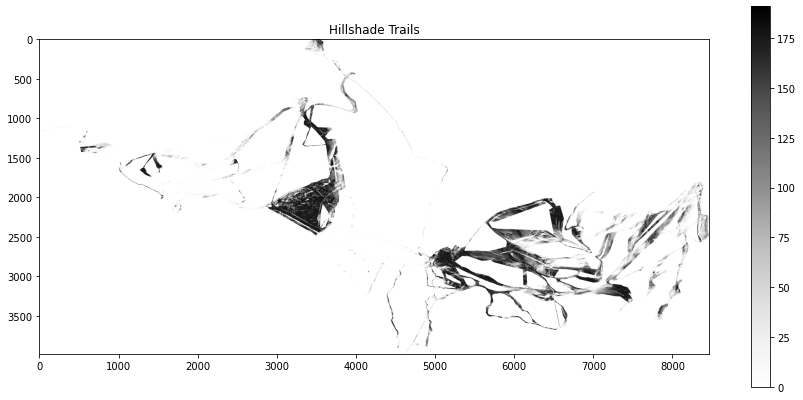

In [13]:
hillshade_img_path = './notebook_outputs/images/trails_hillshade'
plot_rast.plot_raster(hillshade_path, hillshade_img_path, 'Hillshade Trails', cmap = 'Greys')

Calculate the aspect of the dem image: 

In [16]:
aspect_trails_path = './notebook_outputs/rasters/dem_aspect.tif'

aspect_trails = gdal_process.calculate_aspect_dem(dem_cropped_path, aspect_trails_path)
aspect_trails_nodata = np.where(aspect_trails==-9999., 0, aspect_trails)
aspect_trails_nodata = np.nan_to_num(aspect_trails_nodata)

load_rast.write_raster_array(aspect_trails_nodata, dem_cropped_path, aspect_trails_path)

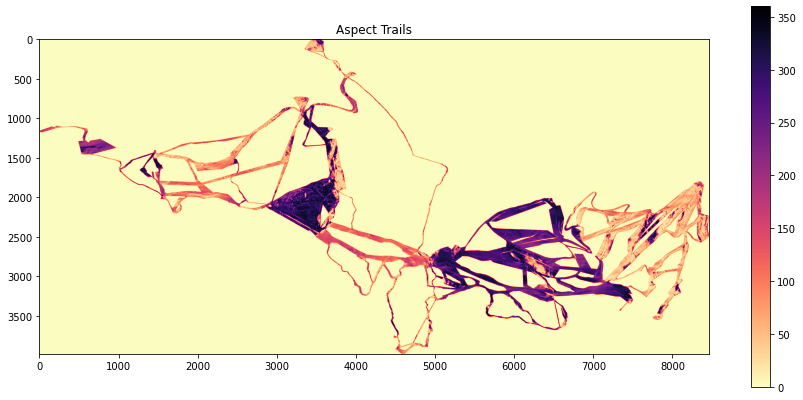

In [17]:
aspect_trails_img_path = './notebook_outputs/images/trails_aspect.png'
plot_rast.plot_raster(aspect_trails_path, aspect_trails_img_path, 'Aspect Trails', cmap='magma_r')

In [18]:
aspect_trails_num = np.nan_to_num(aspect_trails_nodata)

print('min_aspect: ', np.min(aspect_trails_num), ' max_aspect: ', np.max(aspect_trails_num))

min_aspect:  0.0  max_aspect:  359.99377


Calculate the slope of the dem image

In [25]:
slope_trails_path = './notebook_outputs/rasters/dem_slope.tif'
imageio_dem_path = './notebook_outputs/rasters/dem_cropped_imageio.tif'

slope_trails = gdal_process.calculate_slope_dem(imageio_dem_path, slope_trails_path)
slope_trails_nodata = np.where(slope_trails==-9999., np.nan, slope_trails) #noDataVal replacement
slope_trails_nodata = np.where(slope_trails_nodata == 0., np.nan, slope_trails_nodata)

In [26]:
load_rast.write_raster_array(slope_trails_nodata, dem_cropped_path, slope_trails_path)

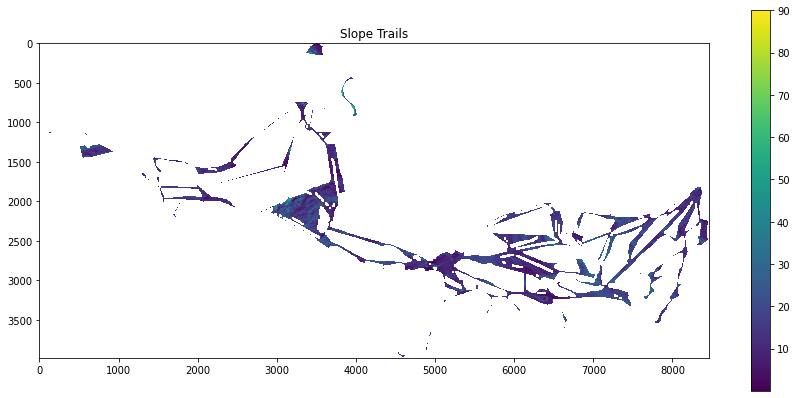

In [27]:
slope_img_path = './notebook_outputs/images/slope_trails.png'
plot_rast.plot_raster(slope_trails_path, slope_img_path, title='Slope Trails', cmap='viridis')

In [28]:
slope_trails_num = np.nan_to_num(slope_trails_nodata)
print('min_slope: ', np.min(slope_trails_num), ' max_slope: ', np.max(slope_trails_num), ' mean_slope: ', np.mean(slope_trails_num))

min_slope:  0.0  max_slope:  90.0  mean_slope:  2.0110772


Histogram of the slopes

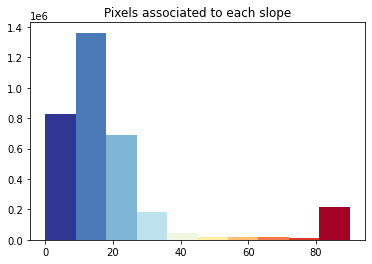

In [29]:
saet_notnan_slope = slope_trails_nodata[~np.isnan(slope_trails_nodata)] #We set all the NaN values to 0 in order to correctly plot the percentatges
saet_notnan_slope = saet_notnan_slope[saet_notnan_slope!=0]
#Plot Histogram: 
cm = plt.cm.get_cmap('RdYlBu_r')
n, bins, patches = plt.hist(saet_notnan_slope, 10, color= 'Green')
bin_centers = 0.5 * (bins[:-1] + bins[1:])

col = bin_centers - min(bin_centers)
col /= max(col)

for c, p in zip(col, patches):
    plt.setp(p, 'facecolor', cm(c))
plt.title('Pixels associated to each slope')
#plt.savefig('./outputs/images/saetde_slope_hist.png')
plt.show()

## Create the mask rasters

In [ ]:
#We are going to create several conditions, an each condition will represent one raster.
#Therefore, we will be able to combine different conditions by only multiplying raster arrays.

In [30]:
#Slope Classification: 
slope_trail = load_rast.open_raster_array(slope_trails_path)

lim1 = 10; lim2 = 20 #Up to 90 degrees
slope_trail_classified = np.copy(slope_trail)

#slope_trail_classified[np.where(slope_trail == 0)] = 1 #Not-employed (threshold values!)
slope_trail_classified[np.where((slope_trail>lim1) & (slope_trail<=lim2))] = 1.
slope_trail_classified[np.where(slope_trail_classified != 1.)] = 0.

In [31]:
#Aspect Classification: 
aspect_trail = load_rast.open_raster_array(aspect_trails_path)

lim1 = 135; lim2 = 225; 
aspect_trail_classified = np.copy(aspect_trail)

#aspect_trail_classified[np.where((aspect_trail>lim1) | (aspect_trail<=lim2))] = 1. #For the north orientation
aspect_trail_classified[np.where((aspect_trail>lim1) & (aspect_trail<=lim2))] = 1.
aspect_trail_classified[np.where(aspect_trail_classified != 1.)] = 0.

dict_aspect_basic = {
  'North' : '315 - 45 degrees',
  'East' : '45 - 135 degrees',
  'South' : '135 - 225 degrees',
  'West' : '225 - 315 degrees'}

dict_aspect_detailed = {
  'North' : '337.5 - 22.5 degrees',
  'North East' : '0 - 45 degrees',
  'East' : '67.5 - 112.5 degrees',
  'South East' : '112.5 - 157.5 degrees',
  'South' : '157.5 - 202.5 degrees',
  'South West' : '202.5 - 247.5 degrees',
  'West' : '247.5 - 292.5 degrees',
  'North West' : '292.5 - 337.5 degrees'}

In [33]:
#Height Classification:
dem_file = load_rast.open_raster_array(dem_cropped_path)
dem_file = np.nan_to_num(dem_file)

lim1 = 1900; lim2 = 2200; 
height_trail_classified = np.copy(dem_file)

height_trail_classified[np.where((dem_file>lim1) & (dem_file<=lim2))] = 1.
height_trail_classified[np.where(height_trail_classified != 1.)] = 0.

## Create a raster with the appropiate conditions

In [35]:
classified_raster = slope_trail_classified * height_trail_classified * aspect_trail_classified
class_raster_path = './notebook_outputs/rasters/classified_raster.tif'
load_rast.write_raster_array(classified_raster, dem_cropped_path, class_raster_path)

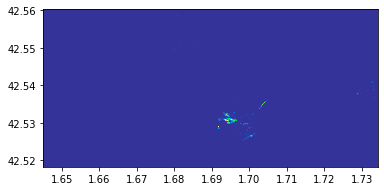

In [36]:
plot_rast.quick_show_rasterio(class_raster_path)

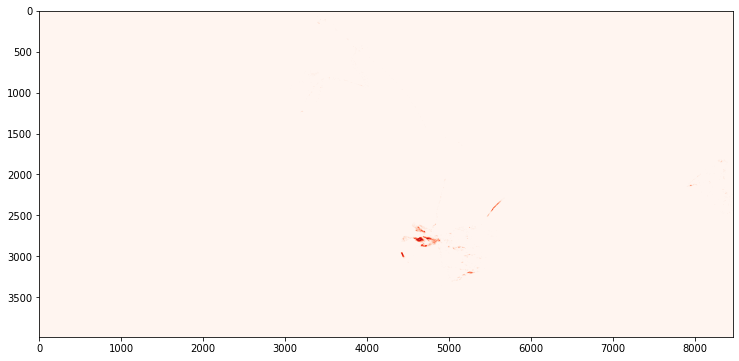

In [37]:
#Imagine we want the polygons containing the points where: 
  #Height : 1700-2300m
  #Slope: 0-10degrees
  #Aspect: South Orientation

clas_raster = load_rast.open_raster_array(class_raster_path)
plt.figure(figsize=(15,6))
plt.imshow(classified_raster, cmap = 'Reds')
ax= plt.gca()
#contextily.add_basemap(ax, crs='EPSG:4326', source=contextily.providers.CartoDB.PositronNoLabels)
#plt.colorbar()
plt.show()

## Extract Coordinates from raster

In [20]:
# We extract the affine transformation associated to the initial raster
raster_dem_file = gdal.Open(class_raster_path, gdal.GA_ReadOnly)
transform_mat_T0 = Affine.from_gdal(*raster_dem_file.GetGeoTransform()) #reference the corner pixel
raster_dem_file = None 

# We define the spatial operator/function that would convert the pixels into coordinates
transform_mat_T1 = transform_mat_T0 * Affine.translation(0.5, 0.5) #reference the center pixel
pixels2xy = lambda r, c: transform_mat_T0 * (c, r)

In [21]:
# We open the original raster that we are going to convert
raster_to_coords = fm.open_raster_array(class_raster_path)
raster_to_coords = np.nan_to_num(raster_to_coords) #We delete all NaN values to avoid problems

# We obtain the length of the original raster
row_len, col_len = np.shape(raster_to_coords)
array_coords = np.zeros((row_len, col_len), dtype=tuple)
arr = np.zeros((1,2), dtype= object)
for i in range(row_len): 
  for j in range(col_len):
    if raster_to_coords[i,j] != 0: 
      val1, val2 = pixels2xy(i,j)
      array_coords[i,j] = val2, val1

print('Shape of the original raster: ', np.shape(raster_to_coords), 'Shape of the new raster', np.shape(array_coords))

Shape of the original raster:  (3982, 8463) Shape of the new raster (3982, 8463)


## Group points into polygons (not employed)

In [22]:
#Set the decimals of a float in a pd.DataFrame to 12 significant digits
pd.options.display.float_format = "{:,.12f}".format

#Delete the cells containing 0., those points aren't interesting for further calculation
array_coords = array_coords[array_coords != 0]

In [23]:
coords_df = pd.DataFrame({'band1' : array_coords})
coords_df['Lon'], coords_df['Lat'] = zip(*coords_df.band1)

In [25]:
#We will create a GeoDataFrame, containing geometries: 
coords_gdf = gpd.GeoDataFrame(coords_df, geometry=gpd.points_from_xy(coords_df.Lat, coords_df.Lon), crs='EPSG:4326')
coords_proj = coords_gdf.to_crs('EPSG:4326')

coords_path = './outputs/shapefile_geojson/coord_files/coords_20deg_2000m.geojson'
coords_proj = coords_proj.drop('band1', axis=1)
coords_proj.to_file(coords_path)

#We create an array cluster: 
coords = coords_proj[['Lon', 'Lat']].values

In [35]:
#Clustering of the array
db = OPTICS(min_samples=2, max_eps=1).fit(coords)

#Setting the labels into the GeoDataFrame
cluster_labels = pd.Series(db.labels_).rename('cluster')
coords_proj = pd.concat([coords_proj, cluster_labels], axis =1)

In [36]:
max_cluster = coords_proj.cluster.max()
max_cluster #We find the total number of clusters of the GeoDataFrame

df_len = len(coords_proj.cluster) #Len of the DataFrame

#We group the GeoDataFrame by taking the cluster number: 
clusters = coords_proj.dissolve(by='cluster')

#Creation of a list of polygons: 
clust_len = len(clusters.geometry)-1
poly_list = []
for i in range(clust_len):
  if len(clusters.geometry[i]) > 3:
    poly = Polygon(clusters.geometry[i])
    poly_list.append(poly)

#Save the polygons as a shapefile: 
poly_gdf = gpd.GeoDataFrame(geometry=poly_list, crs='EPSG:4326')
poly_gdf.to_file('./outputs/shapefile_geojson/polygons/polygons_test.shp')

C:\Users\montse\AppData\Local\Temp\ipykernel_18632\3500916744.py:13: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(clusters.geometry[i]) > 3:
C:\Users\montse\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\shapely\geometry\polygon.py:261: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  ret = geos_polygon_from_py(shell, holes)
C:\Users\montse\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\shapely\geometry\polygon.py:539: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array ins

In [ ]:
#Plot the geometries:
input_shp_file='./outputs/shapefile_geojson/polygons/polygons_test.shp'
shape_f = gpd.read_file(input_shp_file)

fig, ax = plt.subplots(figsize=(15,30))
shape_f.plot(ax=ax, color='Red')
